In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats
from IPython.display import Image
import plotly.io as pio

from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix

import os
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (12, 7)
pd.set_option('display.max_columns', None)

sns.set_style("darkgrid")
%matplotlib inline

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
from plots import Plots
file_handler = FileHandler()
plot = Plots()

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = file_handler.read_csv("../data/cleaned_train.csv")
test_df = file_handler.read_csv("../data/cleaned_test.csv")
store_df = file_handler.read_csv("../data/cleaned_store.csv") 

2022-05-25 17:14:17,717 — FileHandler — DEBUG — file read as csv
2022-05-25 17:14:17,755 — FileHandler — DEBUG — file read as csv
2022-05-25 17:14:17,761 — FileHandler — DEBUG — file read as csv


#### Data Field Description
- `Id` - an Id that represents a(Store, Date) duple within the test set
- `Store` - a unique Id for each store
- `Sales` - the turnover for any given day(this is what you are predicting)
- `Customers` - the number of customers on a given day
- `Open` - an indicator for whether the store was open: 0 = closed, 1 = open
- `StateHoliday` - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- `SchoolHoliday` - indicates if the(Store, Date) was affected by the closure of public schools
- `StoreType` - differentiates between 4 different store models: a, b, c, d
- `Assortment` - describes an assortment level: a = basic, b = extra, c = extended. Read more about assortment here
- `CompetitionDistance` - distance in meters to the nearest competitor store
- `CompetitionOpenSince[Month / Year]` - gives the approximate year and month of the time the nearest competitor was opened
- `Promo` - indicates whether a store is running a promo on that day
- `Promo2` - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- `Promo2Since[Year / Week]` - describes the year and calendar week when the store started participating in Promo2
- `PromoInterval` - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [4]:
stores_types = ["A", "B", "C", "D"]
state_holidays = [ "Normal Day", "Public holiday", "Easter holiday", "Christmas"] 
school_holidays = ["School is closed", "School is open"]
assortment = [ "Basic", "Extra", "Extended"] 
promo = ["Not participating", "Participating"]
store_open = ["Closed", "Open"]

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  int64 
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 69.8+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             41088 non-null  int64 
 1   Store          41088 non-null  int64 
 2   DayOfWeek      41088 non-null  int64 
 3   Date           41088 non-null  object
 4   Open           41088 non-null  int64 
 5   Promo          41088 non-null  int64 
 6   StateHoliday   41088 non-null  int64 
 7   SchoolHoliday  41088 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 2.5+ MB


In [7]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1485,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Store                      1115 non-null   int64
 1   StoreType                  1115 non-null   int64
 2   Assortment                 1115 non-null   int64
 3   CompetitionDistance        1115 non-null   int64
 4   CompetitionOpenSinceMonth  1115 non-null   int64
 5   CompetitionOpenSinceYear   1115 non-null   int64
 6   Promo2                     1115 non-null   int64
 7   Promo2SinceWeek            1115 non-null   int64
 8   Promo2SinceYear            1115 non-null   int64
 9   PromoInterval              1115 non-null   int64
dtypes: int64(10)
memory usage: 87.2 KB


In [9]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [10]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Store                      1115 non-null   int64
 1   StoreType                  1115 non-null   int64
 2   Assortment                 1115 non-null   int64
 3   CompetitionDistance        1115 non-null   int64
 4   CompetitionOpenSinceMonth  1115 non-null   int64
 5   CompetitionOpenSinceYear   1115 non-null   int64
 6   Promo2                     1115 non-null   int64
 7   Promo2SinceWeek            1115 non-null   int64
 8   Promo2SinceYear            1115 non-null   int64
 9   PromoInterval              1115 non-null   int64
dtypes: int64(10)
memory usage: 87.2 KB


In [11]:
train_df.shape, test_df.shape, store_df.shape

((1017209, 9), (41088, 8), (1115, 10))

Merge store dataframe to train and test dataframes

In [12]:
train_df = pd.merge(train_df, store_df, how = 'left', on = 'Store')
test_df = pd.merge(test_df, store_df, how = 'left', on = 'Store')

In [13]:
# The types and shape of data features in the dataset

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   Store                      1017209 non-null  int64 
 1   DayOfWeek                  1017209 non-null  int64 
 2   Date                       1017209 non-null  object
 3   Sales                      1017209 non-null  int64 
 4   Customers                  1017209 non-null  int64 
 5   Open                       1017209 non-null  int64 
 6   Promo                      1017209 non-null  int64 
 7   StateHoliday               1017209 non-null  int64 
 8   SchoolHoliday              1017209 non-null  int64 
 9   StoreType                  1017209 non-null  int64 
 10  Assortment                 1017209 non-null  int64 
 11  CompetitionDistance        1017209 non-null  int64 
 12  CompetitionOpenSinceMonth  1017209 non-null  int64 
 13  CompetitionOpenSinceYear   

In [14]:
# The types and shape of data features in the dataset

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Id                         41088 non-null  int64 
 1   Store                      41088 non-null  int64 
 2   DayOfWeek                  41088 non-null  int64 
 3   Date                       41088 non-null  object
 4   Open                       41088 non-null  int64 
 5   Promo                      41088 non-null  int64 
 6   StateHoliday               41088 non-null  int64 
 7   SchoolHoliday              41088 non-null  int64 
 8   StoreType                  41088 non-null  int64 
 9   Assortment                 41088 non-null  int64 
 10  CompetitionDistance        41088 non-null  int64 
 11  CompetitionOpenSinceMonth  41088 non-null  int64 
 12  CompetitionOpenSinceYear   41088 non-null  int64 
 13  Promo2                     41088 non-null  int64 
 14  Promo2

Remove Id column from test dataframe

In [15]:
ID = test_df['Id']
test_df.drop('Id',inplace=True,axis=1)

In [16]:
test_df.describe()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000
mean,555.900,3.979,0.854,0.396,0.004,0.443,1.252,1.001,4456.861,4.800,2001.738,0.581,14.182,2001.738,0.932
std,320.274,2.015,0.353,0.489,0.066,0.497,1.397,0.995,4910.183,3.836,10.521,0.493,16.178,10.521,0.989
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,20.000,1.000,1900.000,0.000,0.000,1900.000,0.000
25%,279.750,2.000,1.000,0.000,0.000,0.000,0.000,0.000,720.000,1.000,1990.000,0.000,0.000,1990.000,0.000
50%,553.500,4.000,1.000,0.000,0.000,0.000,0.000,1.000,2410.000,4.000,2005.000,1.000,9.000,2005.000,1.000
75%,832.250,6.000,1.000,1.000,0.000,1.000,3.000,2.000,6435.000,9.000,2011.000,1.000,31.000,2011.000,1.000
max,1115.000,7.000,1.000,1.000,1.000,1.000,3.000,2.000,16107.000,12.000,2015.000,1.000,49.000,2015.000,3.000


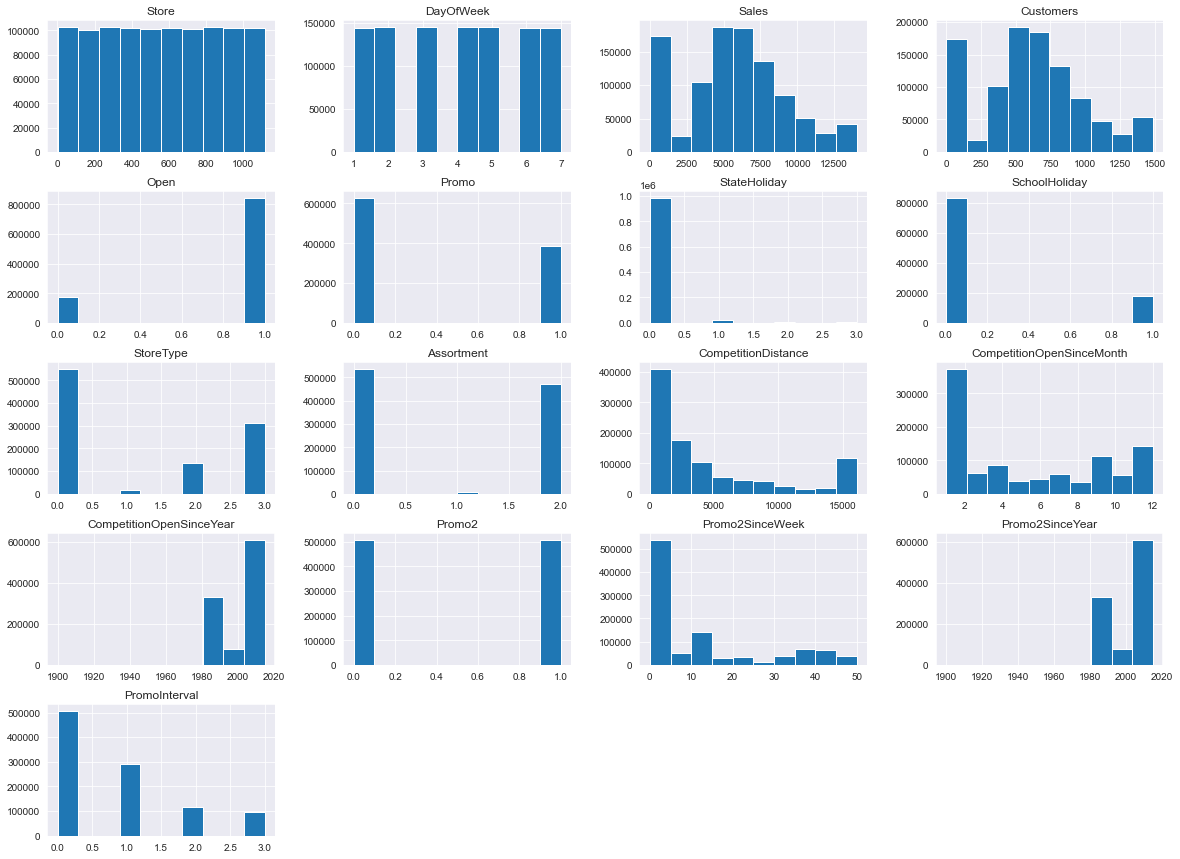

In [17]:
# Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));